In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

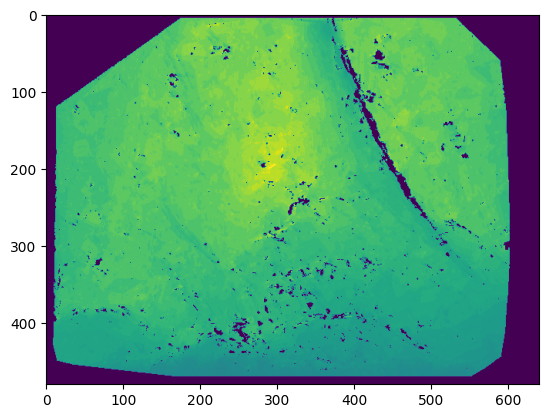

In [2]:
# path = './predicted_depths/depth000000.png'
# path = '/media/thesis_ssd/temp_test/depth000101.png'
path ='/media/thesis_ssd/data/Hamlyn/rectified01/depth02/0000000010.png'
img = mpimg.imread(path)
plt.imshow(img)

In [3]:
img.max()

0.0017547875

In [4]:
import os
import datasets.scared_dataset
import torch
import numpy as np
def readlines(filename):
    """Read all the lines in a text file and return as a list
    """
    with open(filename, 'r') as f:
        lines = f.read().splitlines()
    return lines

data_path = "/media/thesis_ssd/data/SCARED" 
filenames = readlines(os.path.join('splits/endovis/test_files.txt'))
dataset = datasets.scared_dataset.SCAREDRAWDataset(data_path, filenames,
                                336, 336,
                                [0], 4, is_train=False)


dataloader = torch.utils.data.DataLoader(dataset, 2, shuffle=True, num_workers=1,
                        pin_memory=True, drop_last=False)

In [5]:
import torchvision.transforms as transforms
import random


colorjitter = transforms.ColorJitter(0.5,0.5,0.5,0.5)
gaussianblur = transforms.GaussianBlur(9)


def obtain_cutmix_box(img_size, p=0.5, size_min=0.02, size_max=0.1, ratio_1=0.3, ratio_2=1/0.3):
    mask = torch.zeros(img_size, img_size)
    if random.random() > p:
        return mask

    size = np.random.uniform(size_min, size_max) * img_size * img_size
    while True:
        ratio = np.random.uniform(ratio_1, ratio_2)
        cutmix_w = int(np.sqrt(size / ratio))
        cutmix_h = int(np.sqrt(size * ratio))
        x = np.random.randint(0, img_size)
        y = np.random.randint(0, img_size)

        if x + cutmix_w <= img_size and y + cutmix_h <= img_size:
            break

    mask[y:y + cutmix_h, x:x + cutmix_w] = 1

    return mask

def cutmix_augmentation(data,p = 0.5):
    IMG_SIZE = 336
    imgs = data[('color',0,0)].cuda()
    imgs_mixed = imgs.clone()
    for i in range(torch.floor_divide(len(imgs),2)):
        mask = 1-obtain_cutmix_box(IMG_SIZE,p = p).cuda()
        imgs_mixed[2*i] = mask*imgs[2*i]+(1-mask)*imgs[2*i+1]
        imgs_mixed[2*i+1] = mask*imgs[2*i+1]+(1-mask)*imgs[2*i]
    return imgs,imgs_mixed


In [6]:
for data in dataloader:
    break

[ WARN:0@1.210] global loadsave.cpp:241 findDecoder imread_('/media/thesis_ssd/data/SCARED/test/dataset_6/keyframe_4/data/scene_points/scene_points001321.tiff'): can't open/read file: check file path/integrity
[ WARN:0@1.270] global loadsave.cpp:241 findDecoder imread_('/media/thesis_ssd/data/SCARED/test/dataset_4/keyframe_4/data/scene_points/scene_points000009.tiff'): can't open/read file: check file path/integrity
[ WARN:0@1.324] global loadsave.cpp:241 findDecoder imread_('/media/thesis_ssd/data/SCARED/test/dataset_2/keyframe_4/data/scene_points/scene_points001111.tiff'): can't open/read file: check file path/integrity


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/media/thesis_ssd/anaconda/envs/depth_eval_3/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/media/thesis_ssd/anaconda/envs/depth_eval_3/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/media/thesis_ssd/anaconda/envs/depth_eval_3/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/media/thesis_ssd/code/Depth_evaluation/datasets/mono_dataset.py", line 189, in __getitem__
    depth_gt = self.get_depth(folder, frame_index, side, do_flip)
  File "/media/thesis_ssd/code/Depth_evaluation/datasets/scared_dataset.py", line 61, in get_depth
    depth_gt = depth_gt[:, :, 0]
TypeError: 'NoneType' object is not subscriptable


In [ ]:
img = data[('color',0,0)][0]
imgs,imgs_mixed = cutmix_augmentation(data,1)

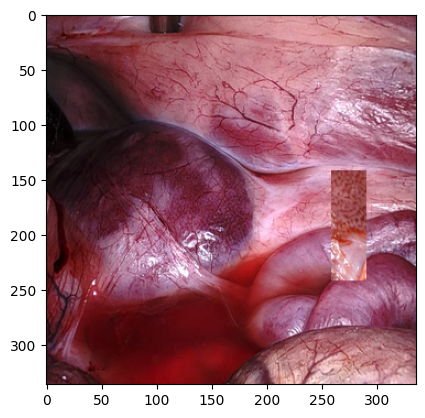

In [ ]:
plt.imshow(imgs_mixed[0].permute(1,2,0).cpu())

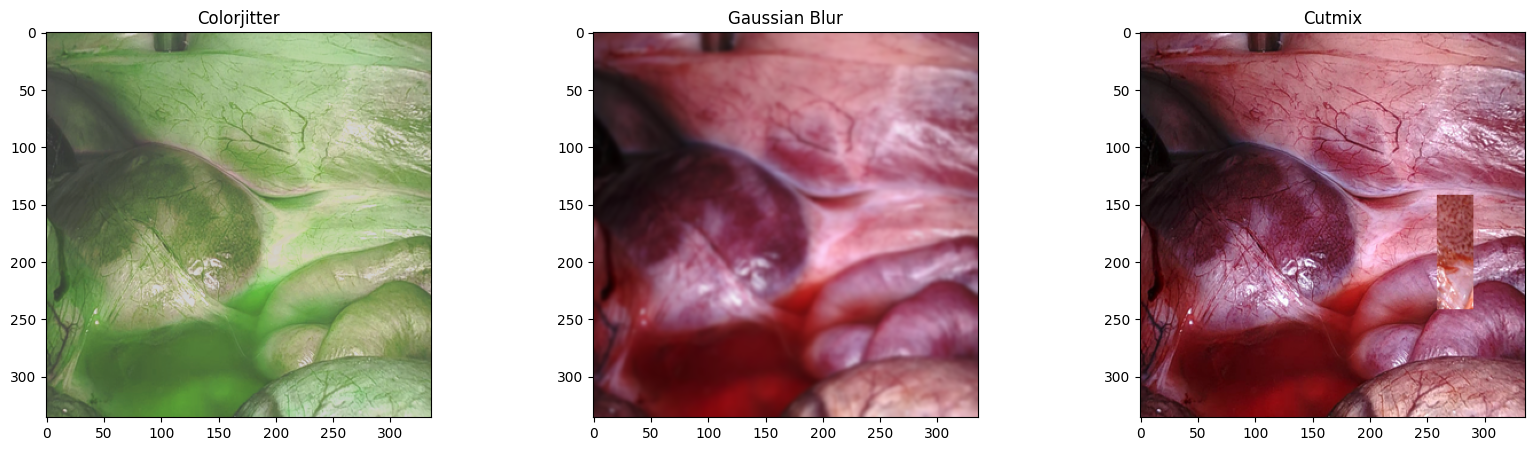

In [ ]:
img_jittered = colorjitter(img)
img_blurred = gaussianblur(img)
img_mixed = imgs_mixed[0]
fig,ax = plt.subplots(1,3,figsize = (20,5))
ax[0].set_title('Colorjitter')
ax[0].imshow(img_jittered.permute(1,2,0))
ax[1].set_title('Gaussian Blur')
ax[1].imshow(img_blurred.permute(1,2,0))
ax[2].set_title('Cutmix')
ax[2].imshow(img_mixed.permute(1,2,0).cpu())

In [ ]:
from models.SurgeDepth.dpt import SurgeDepth

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}
model = SurgeDepth(**model_configs['vitb']).cuda()
torch.no_grad()
state_dict = torch.load('models/SurgeDepth/SurgeDepth_V7.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
import torchvision
from PIL import Image
for id,data in enumerate(dataloader):
    input_color = data[("color", 0, 0)].cuda()
    input_depth = data[]
    # input_color = transform({'image': input_color})['image']
    
    input_color = torchvision.transforms.functional.normalize(input_color,mean=[0.46888983, 0.29536288, 0.28712815], std=[0.24689102 ,0.21034359, 0.21188641])
    pred_disp = model(input_color)
    pred_disp_normalized = (pred_disp-pred_disp.min())/(pred_disp.max()-pred_disp.min())*9+1
    pred_depth = 1/pred_disp_normalized
    
    pred_depth = (pred_depth-pred_depth.min())/(pred_depth.max()-pred_depth.min())*255
    pred_depth = pred_depth[0].cpu().detach().numpy()
    pred_depth = pred_depth.astype(np.uint8)
    # print(pred_depth.shape)
    # print(pred_depth.max())
    # plt.imsave('predicted_depths/depth{:06d}.png'.format(id),pred_depth,cmap='gray')
    # im = Image.fromarray(pred_depth)
    # im.save('predicted_depths/depth{:06d}.png'.format(id))
    # im = im.convert('Grayscale')
    # torchvision.utils.save_image(pred_depth[0],'predicted_depths/depth{:06d}.png'.format(id),format ='RGB')
    # fig,ax = plt.subplots(1,2)
    # ax[0].imshow(input_color[0].permute(1,2,0).cpu().detach().numpy())
    # ax[1].imshow(pred_disp[0].cpu().detach().numpy())
    # plt.show()
    if id>1:
        break
    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6609203..3.3644059].


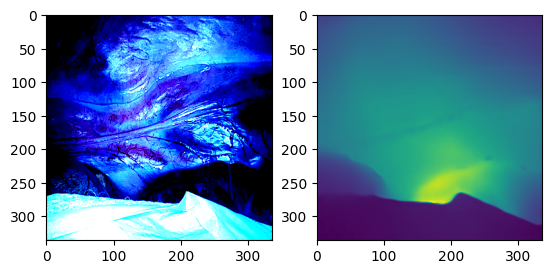

In [ ]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(input_color[0].permute(1,2,0).cpu().detach().numpy())
ax[1].imshow(pred_depth)


In [ ]:
dataset.load_depth

False

## Section


In [ ]:
from datasets.hamlyn_dataset import HamlynDataset
import torchvision.transforms as tf
import torch

transforms = tf.Compose([tf.Resize((336,336),antialias = True),tf.ConvertImageDtype(torch.float32)])
transforms_depth = tf.Compose([tf.ToTensor()])

dataset = HamlynDataset(depth_dir='/media/thesis_ssd/data/Hamlyn/rectified01/depth01/',rgb_dir='/media/thesis_ssd/data/Hamlyn/rectified01/image01/',transform_img=transforms,transform_depth=transforms_depth)
dataset[0].keys()

dict_keys(['rgb', 'depth', 'id'])

In [ ]:
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
lpips = LearnedPerceptualImagePatchSimilarity(net_type='alex')
# lpips(dataset[0]['depth'],dataset[0]['depth'])
depth = dataset[0]['depth']
depth_lpips = depth.unsqueeze(0)
depth_lpips = depth_lpips.repeat(1,3,1,1)

depth1 = dataset[1]['depth']
depth_lpips1 = depth1.unsqueeze(0)
depth_lpips1 = depth_lpips1.repeat(1,3,1,1)
lpips(depth_lpips,depth_lpips1)

/media/thesis_ssd/anaconda/envs/depth_eval_3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/thesis_ssd/anaconda/envs/depth_eval_3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor(0.7275, grad_fn=<SqueezeBackward0>)

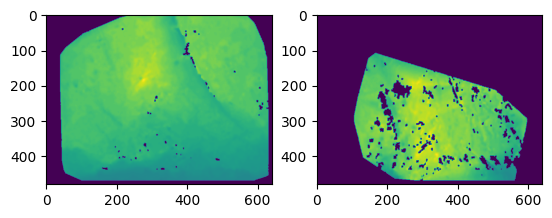

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,2)
ax[0].imshow(depth_lpips[0,1,:,:])
ax[1].imshow(depth_lpips1[0,1,:,:])

In [1]:
s_gt = [0.003698359191614845, 0.0038439831559723865, 0.003479259614585387, 0.0035963084660244095, 0.00347882932463828, 0.003693847735712928, 0.0038957629943814007, 0.0034739761704740964, 0.003857673415959304, 0.0036829398364131034, 0.0037835753490165274, 0.003819995188714639, 0.0037381016093398956, 0.0036455112688807655, 0.0037307452319865018, 0.0037141516776600194, 0.0034152252827302004, 0.00356930556112649, 0.0034439494653497075, 0.003609006455437428, 0.0035416469016283565, 0.0037399430815753024, 0.0037233193060067066, 0.0036400673656021925, 0.0035657942622792133, 0.0037507715804588984, 0.003463062647932865, 0.003608074958158926, 0.00372561039481843, 0.003426928719845243, 0.0037331462396264377, 0.0035135011895244222, 0.0038039379940337753, 0.0037545193040967434, 0.0035086560029447414, 0.0037798764945785757, 0.0034257878539259907, 0.003598583825259792, 0.003832036588451327, 0.0038187850600776563, 0.0034476928990177865, 0.0037342584218427897, 0.003423133917988548, 0.003704125991869585, 0.3603860785678968, 0.0036940466186247893, 0.0038177614615256183, 0.0034517814143727086, 0.003490100592719495, 0.003748822312217718, 0.003745973182789272, 0.003733481953774146, 0.0034549014719323767, 0.0036957663743517727, 0.0034125904524499573, 0.0035713190997515654, 0.00356671092417435, 0.003794654717076553, 0.0038644787059158355, 0.003612106890986365, 0.0036294668023050514, 0.003762704878095786, 0.0037517799416240433, 0.003759852327580918, 0.003894342772113985, 0.003591655824064672, 0.0037468860966509867, 0.003841582834614487, 0.00373749347470459, 0.003832601540882214, 0.003511773584407704, 0.0035825881442493146, 0.003627209199629415, 0.003688561111757735, 0.003747013816549556, 0.0038438661595714615, 0.0034996949551919657, 0.003566259315970687, 0.0038877835901562166, 0.003302052548328758, 0.0036979546965236016, 0.0035473757408005873, 0.003814805081341367, 0.0036386230019813557, 0.0034422951665053943, 0.003675634309774306, 0.003340488871765005, 0.0038899026307483123, 0.00354788169251402, 0.0034574206677642056, 0.0037027243064344704, 0.0036979310204719165, 0.0036893919201087203, 0.003529837462724241, 0.0038088449021848525, 0.0037059579793096574, 0.0035762607761955236, 0.0035685457217615496, 0.0036262417338197932, 0.0034721612521324595, 0.0038253771698801256, 0.003407837293421168, 0.0034070140753192334, 0.003492103001612573, 0.0038214572298061835, 0.0035491226121861057, 0.0033744422056425118, 0.0036053116918211255, 0.0035671662859803996, 0.0035702205936597566, 0.003688520819013241, 0.0036634034702206554, 0.00359343927041778, 0.003736476078195823, 0.003705855776068866, 0.0036607796536968873, 0.003746782890760725, 0.0035795820787977543, 0.003593398497958366, 0.003452764139521275, 0.003764739871211764, 0.0037775284727735725, 0.0034084975390644263, 0.003842422281811078, 0.0035550017651180786, 0.003696409125709462, 0.003712703957689879, 0.0037890378086083503, 0.003625107475533519, 0.0035224135306473055, 0.0038282129108201998, 0.0034853230906838183, 0.0037327121462797054, 0.0034735045818972167, 0.003553580849434458, 0.003532194958516771, 0.0037607964844444067, 0.0034774203461005555, 0.003721046075883008, 0.0037598975976551314, 0.003803354966019373, 0.003821542771525882, 0.0036666756656774514, 0.00351045342923141, 0.0033685645867233428, 0.0034687791332377563, 0.003748811253858638]
t_gt = [0.017241379310344827, 0.017241379310344827, 0.016666666666666666, 0.016666666666666666, 0.016666666666666666, 0.016666666666666666, 0.017241379310344827, 0.01639344262295082, 0.01694915254237288, 0.017543859649122806, 0.017241379310344827, 0.017543859649122806, 0.01694915254237288, 0.01694915254237288, 0.017241379310344827, 0.017241379310344827, 0.016666666666666666, 0.016666666666666666, 0.016666666666666666, 0.017241379310344827, 0.016666666666666666, 0.017241379310344827, 0.01694915254237288, 0.01694915254237288, 0.01694915254237288, 0.017543859649122806, 0.016666666666666666, 0.01694915254237288, 0.017241379310344827, 0.016666666666666666, 0.01694915254237288, 0.016666666666666666, 0.017543859649122806, 0.017543859649122806, 0.01639344262295082, 0.017241379310344827, 0.01639344262295082, 0.01694915254237288, 0.017241379310344827, 0.017543859649122806, 0.01639344262295082, 0.017543859649122806, 0.016666666666666666, 0.017241379310344827, 0.5, 0.01694915254237288, 0.017241379310344827, 0.016666666666666666, 0.016666666666666666, 0.017241379310344827, 0.01694915254237288, 0.01694915254237288, 0.016666666666666666, 0.017241379310344827, 0.016666666666666666, 0.01694915254237288, 0.016666666666666666, 0.017543859649122806, 0.017543859649122806, 0.01694915254237288, 0.01694915254237288, 0.017543859649122806, 0.017543859649122806, 0.01694915254237288, 0.017543859649122806, 0.01694915254237288, 0.01694915254237288, 0.017543859649122806, 0.017241379310344827, 0.017543859649122806, 0.016666666666666666, 0.016666666666666666, 0.01694915254237288, 0.017543859649122806, 0.017241379310344827, 0.01694915254237288, 0.016666666666666666, 0.016666666666666666, 0.017241379310344827, 0.01639344262295082, 0.017241379310344827, 0.016666666666666666, 0.017543859649122806, 0.01694915254237288, 0.016666666666666666, 0.016666666666666666, 0.01639344262295082, 0.017241379310344827, 0.016666666666666666, 0.016666666666666666, 0.017241379310344827, 0.01694915254237288, 0.017543859649122806, 0.016666666666666666, 0.017543859649122806, 0.017543859649122806, 0.01694915254237288, 0.016666666666666666, 0.017543859649122806, 0.01639344262295082, 0.017241379310344827, 0.016666666666666666, 0.01639344262295082, 0.016666666666666666, 0.01694915254237288, 0.016666666666666666, 0.016666666666666666, 0.01694915254237288, 0.016666666666666666, 0.016666666666666666, 0.017241379310344827, 0.017241379310344827, 0.01694915254237288, 0.017241379310344827, 0.016666666666666666, 0.016666666666666666, 0.017241379310344827, 0.016666666666666666, 0.016666666666666666, 0.016666666666666666, 0.017241379310344827, 0.017543859649122806, 0.016666666666666666, 0.01694915254237288, 0.01694915254237288, 0.017241379310344827, 0.017241379310344827, 0.017543859649122806, 0.016666666666666666, 0.016666666666666666, 0.017241379310344827, 0.016666666666666666, 0.01694915254237288, 0.016666666666666666, 0.016666666666666666, 0.016666666666666666, 0.016666666666666666, 0.016666666666666666, 0.017241379310344827, 0.017543859649122806, 0.017241379310344827, 0.017241379310344827, 0.016666666666666666, 0.016666666666666666, 0.016666666666666666, 0.016666666666666666, 0.017241379310344827]
s_pred = [0.5809996, 0.617853, 0.58290136, 0.58502644, 0.5008978, 0.5919084, 0.5759812, 0.6289471, 0.4831553, 0.5234012, 0.57249206, 0.6104317, 0.6689792, 0.5962997, 0.5771641, 0.5867963, 0.5799011, 0.5232443, 0.5929726, 0.63314223, 0.5962339, 0.66264814, 0.46224463, 0.59668297, 0.6031173, 0.6434778, 0.61127216, 0.6441022, 0.6071471, 0.62794286, 0.66879684, 0.5830089, 0.6207292, 0.5415076, 0.61888516, 0.62197655, 0.59395397, 0.6122033, 0.59421897, 0.55623513, 0.57945764, 0.5350146, 0.6338327, 0.5989728, 0.10310573, 0.60626763, 0.607481, 0.58407366, 0.6174637, 0.5603559, 0.6267785, 0.6518479, 0.6159374, 0.712829, 0.6103104, 0.59909266, 0.62212086, 0.553025, 0.6141162, 0.59168196, 0.540826, 0.5007753, 0.5497814, 0.5797104, 0.6114416, 0.69427603, 0.6435358, 0.4982116, 0.61258245, 0.62989956, 0.5747734, 0.62048066, 0.5274525, 0.6508041, 0.6074063, 0.46924374, 0.6204213, 0.6108246, 0.61886036, 0.6110563, 0.58565736, 0.5611858, 0.6096441, 0.5828459, 0.62083036, 0.5173284, 0.62029403, 0.6242921, 0.6152101, 0.5232762, 0.60008746, 0.5693004, 0.53713286, 0.5895268, 0.5522637, 0.60261726, 0.6260615, 0.59262294, 0.7237428, 0.6230648, 0.6308018, 0.5832657, 0.63443786, 0.618379, 0.52920026, 0.5313944, 0.6265826, 0.5975165, 0.615248, 0.5650726, 0.6797121, 0.6192436, 0.6410654, 0.5945116, 0.59027714, 0.59192514, 0.5652873, 0.6200569, 0.595851, 0.6292697, 0.6233822, 0.57964754, 0.6293947, 0.5032222, 0.5210261, 0.6715985, 0.6115423, 0.6435707, 0.6026641, 0.61397105, 0.6149799, 0.631069, 0.54528016, 0.5033765, 0.5036724, 0.5743662, 0.46380258, 0.6092621, 0.6548869, 0.60208946, 0.61570144, 0.6091471, 0.5854838, 0.63454455, 0.61197686, 0.61960727, 0.56358224]
t_pred = [2.1031954, 2.1980512, 1.960392, 1.9900668, 1.8633573, 1.9921138, 2.1232114, 2.0898702, 1.8321465, 1.8931537, 2.0932167, 2.153387, 2.3703842, 2.2329776, 2.0745773, 2.1317961, 2.0479174, 1.8440819, 2.050523, 2.2052917, 2.0342326, 2.3316455, 1.8009727, 2.2159364, 2.2621398, 2.2189484, 2.1025462, 2.0696318, 2.150322, 2.108286, 2.3453674, 2.026536, 2.2022066, 1.9208285, 2.0516942, 2.2511861, 2.0771823, 2.0567663, 2.114455, 2.00029, 2.0538373, 1.9063461, 2.1182594, 2.1442318, 2.8587744, 2.2717307, 2.2410407, 2.0511253, 2.121214, 2.037334, 2.303887, 2.3493443, 2.1163206, 2.3135629, 2.0828884, 2.238233, 2.1225529, 2.000193, 2.1682, 2.2184303, 1.9271066, 1.872264, 1.9322926, 2.118895, 2.1787012, 2.2876418, 2.2868645, 1.8719687, 2.1560287, 2.1981392, 2.027015, 2.0506985, 1.9011242, 2.2341747, 2.1539097, 1.8186985, 2.12345, 2.1085987, 2.2136965, 2.0817733, 2.0997252, 2.0222847, 2.1674337, 2.015287, 2.0822656, 1.839127, 2.0632482, 2.1846404, 2.1167564, 1.8340428, 2.1462736, 1.9721084, 1.9164772, 2.068009, 1.9620878, 2.1525145, 2.0360248, 2.0738964, 2.331768, 2.064441, 2.2062936, 2.0622206, 2.1113794, 2.131328, 1.9123306, 1.8632431, 2.0698557, 2.2399833, 2.1062288, 1.9642512, 2.275111, 2.1680803, 2.0969744, 2.126264, 1.9960645, 2.011279, 2.0881515, 2.1057177, 2.0825286, 2.0292141, 2.1990495, 2.1161666, 2.1007414, 1.8614162, 1.8909853, 2.2624393, 2.1622474, 2.2210588, 2.033529, 2.09457, 2.1839113, 2.1512353, 1.9282906, 1.8879104, 1.8616533, 2.029739, 1.804078, 2.0745723, 2.3559017, 2.1429763, 2.22956, 2.1765957, 1.9932933, 2.1538088, 2.0629988, 2.043967, 2.0736275]

In [2]:
s_gt.extend([0.003154244138212131, 0.0023724398002148003, 0.0028715398891177536, 0.002793051197325029, 0.003000357140391778, 0.00281136520504665, 0.002239978199888535, 0.0029545966359063158, 0.00285501888050187, 0.002197227395329937, 0.002949843389399049, 0.002915021338929893, 0.002203895255709682, 0.002966735880574171, 0.002999268818557337, 0.002790529285592465, 0.0026703709002072543, 0.0030433044256732104, 0.003005202137294984, 0.0023458915991474436, 0.0031705536739013384, 0.002131431492036433, 0.0024282289510045314, 0.0028508151168718065, 0.002626401772255116, 0.0022761509688026074, 0.0027916681779656858, 0.0028812265991423687, 0.002118460055076388, 0.0021329840672847764, 0.0024803068579746465, 0.0024106304794262777, 0.0029683985118859695, 0.0030286393027664045, 0.002244018118533179, 0.002179697403576679, 0.0029625619282332783, 0.0028266346784249735, 0.0025066036519388463])
t_gt.extend([0.014705882352941176, 0.013513513513513514, 0.014492753623188406, 0.015151515151515152, 0.014705882352941176, 0.014285714285714285, 0.015151515151515152, 0.014492753623188406, 0.013888888888888888, 0.013888888888888888, 0.015151515151515152, 0.014705882352941176, 0.015151515151515152, 0.014705882352941176, 0.014285714285714285, 0.014285714285714285, 0.014084507042253521, 0.014084507042253521, 0.014705882352941176, 0.015625, 0.014285714285714285, 0.014925373134328358, 0.015625, 0.015384615384615385, 0.014285714285714285, 0.014705882352941176, 0.014285714285714285, 0.014285714285714285, 0.014925373134328358, 0.015151515151515152, 0.015625, 0.013888888888888888, 0.014285714285714285, 0.014084507042253521, 0.014084507042253521, 0.014925373134328358, 0.014285714285714285, 0.013888888888888888, 0.013888888888888888])
s_pred.extend([0.34829366, 0.37198806, 0.38041106, 0.37008986, 0.34895143, 0.38604143, 0.34437668, 0.3590287, 0.31311023, 0.37273479, 0.35919017, 0.35611224, 0.35022, 0.36821997, 0.3188918, 0.38620058, 0.36945143, 0.3224481, 0.3566158, 0.34099025, 0.3339059, 0.3439432, 0.34585, 0.35989517, 0.31796312, 0.39286402, 0.32397324, 0.3244893, 0.34520656, 0.335743, 0.35495785, 0.36103204, 0.3335191, 0.33748987, 0.3997921, 0.37243512, 0.34290627, 0.32427272, 0.37653652])
t_pred.extend([1.7464383, 1.7722696, 1.8120173, 1.729171, 1.7421308, 1.840725, 1.734886, 1.75387, 1.6439695, 1.7714069, 1.7077323, 1.7798579, 1.7493857, 1.7860289, 1.6604239, 1.8251092, 1.7565813, 1.6730742, 1.7448144, 1.7204542, 1.7124512, 1.7399261, 1.7312969, 1.7291851, 1.6319648, 1.8185302, 1.670302, 1.6686287, 1.7468227, 1.7173935, 1.7261186, 1.7598749, 1.7359483, 1.6800945, 1.8306113, 1.7832286, 1.7520373, 1.6535351, 1.8013784])


In [9]:
s_gt_scared=[0.002225363, 0.0032641336, 0.0010841128, 0.0022819464, 0.003208901, 0.001705117, 0.0037164732, 0.0035177744, 0.0049243364, 0.0019483027, 0.0016780032, 0.002774718, 0.0039353934, 0.00480702, 0.0020202638, 0.002816201, 0.0011895928, 0.0036606798, 0.0016190036, 0.0026987814, 0.0043306495, 0.0016241516, 0.0007397891, 0.0020066388, 0.0041165394, 0.0008245852, 0.0025108617, 0.0017564934, 0.0033726224, 0.0019718194, 0.00421698, 0.001614565, 0.0011216606, 0.0016154173, 0.0020968153, 0.0036124708, 0.0035775688, 0.002801398, 0.0019676702, 0.0029782215, 0.002064392, 0.0016056338, 0.0024642642, 0.0019852242, 0.0014529936, 0.0044317446, 0.0019147277, 0.001752291, 0.00053018134, 0.00196936, 0.0005829342, 0.002301191, 0.0011124272, 0.0022156183, 0.00073653413, 0.0017323437, 0.005778051, 0.00077425496, 0.0033821263, 0.0019623411, 0.00271131, 0.0020713664, 0.0015164473, 0.002287384, 0.0024783895, 0.0019623477, 0.0020415024, 0.0032188795, 0.0010147498, 0.0007533306, 0.0020284008, 0.002918847, 0.0017936813, 0.0025252926, 0.0019351695, 0.0026266742, 0.002001018, 0.00078048557, 0.001911963, 0.0029651276, 0.003074566, 0.004186784, 0.0017292853, 0.004542168, 0.0021009815, 0.0036484352, 0.0020521455, 0.0016126204, 0.0012297397, 0.00195576, 0.0007692415, 0.0019025282, 0.0008932249, 0.001810826, 0.0023601095, 0.0026061109, 0.00093991857, 0.0020507607, 0.0026792171, 0.0029712936, 0.002086391, 0.0029063795, 0.0008640312, 0.004031343, 0.0018633396, 0.0014862465, 0.0019859937, 0.0010245624, 0.0020088428, 0.0027146863, 0.0007207931, 0.00056334503, 0.0019068465, 0.0024430628, 0.0032339261, 0.0044817827, 0.0020431885, 0.0022998292, 0.0026392438, 0.0028112554, 0.0019940974, 0.0018706445, 0.0023465448, 0.0005151401, 0.0022267287, 0.0024344213, 0.0016976241, 0.002011741, 0.0025851028, 0.0022981234, 0.0036298456, 0.00419972, 0.0016829754, 0.011140488, 0.002018916, 0.0016574332, 0.0020075047, 0.0020187926, 0.0008561657, 0.001337575, 0.00347123, 0.0036548555, 0.0017482936, 0.002201645, 0.0016675586, 0.0024079573, 0.0017775925, 0.0019762756, 0.0028521821, 0.0027460933, 0.0031160417, 0.001523044, 0.0026210404, 0.0020873747, 0.0020243842, 0.004941208, 0.0019815606, 0.0025513468, 0.0014223615, 0.002028066, 0.0015160639, 0.002395372, 0.0014750218, 0.0007451813, 0.0014700689, 0.001845467, 0.0014365894, 0.003593653, 0.0021873058, 0.0022111775, 0.0026844621, 0.0009991443, 0.0031436288, 0.0015464164, 0.00091944175, 0.0023921356, 0.000922675, 0.0023479005, 0.004369529, 0.002130115, 0.0009351037, 0.0020101233, 0.0014488464, 0.0015368862, 0.0014915547, 0.00123285, 0.0013939586, 0.001983053, 0.0019608086, 0.0019902226, 0.0017359256, 0.002368066, 0.0020749292, 0.002172218, 0.0017536731, 0.001142795, 0.0013878411, 0.00080435997, 0.0019174584, 0.0007925474, 0.0022708885, 0.00075980753, 0.0014200012, 0.0019925672, 0.003002188, 0.0017631927, 0.0015717646, 0.0018563566, 0.0021377017, 0.0019113875, 0.0019449063, 0.002053588, 0.003766476, 0.0024081839, 0.002062569, 0.0036127826, 0.003903614, 0.0010782433, 0.0015869635, 0.0025396592, 0.0014338427, 0.0031202238, 0.0012919317, 0.0016892861, 0.0017560776, 0.00187601, 0.0025878851, 0.0029738063, 0.00071608485, 0.0018666395, 0.0032615585, 0.002192657, 0.0017074919, 0.00078773237, 0.0020434135, 0.00074775936, 0.001484057, 0.003944186, 0.00097130093, 0.0025485384, 0.0014622416, 0.001024219, 0.0037009045, 0.0020052437, 0.0020732973, 0.0016235405, 0.0025115253, 0.0022384792, 0.0031988774, 0.001977603, 0.0010347096, 0.0019855574, 0.0023302538, 0.002245925, 0.0018815257, 0.0019082455, 0.0017212844, 0.0068488615, 0.0007417696, 0.0017462705, 0.0022515338, 0.0019006492, 0.0041338857, 0.0019615022, 0.0018045596, 0.0009486531, 0.0011348777, 0.0024202801, 0.002082803, 0.00081362826, 0.001867652, 0.0007004773, 0.00083720614, 0.001702921, 0.0036140676, 0.0029154683, 0.0017785296, 0.00059175026, 0.0021289885, 0.0030872903, 0.0045942417, 0.0013714307, 0.0016487063, 0.0021851447, 0.0019804358, 0.0006709182, 0.012911157, 0.0026679107, 0.0021510364, 0.00123614, 0.0049699647, 0.0016551346, 0.0033293078, 0.0023250894, 0.0016854368, 0.0011012692, 0.0019977128, 0.0022230137, 0.0036407076, 0.00090785674, 0.0023730334, 0.0033740073, 0.0022845995, 0.0018771935, 0.0018087846, 0.00079593767, 0.002789023, 0.0029221424, 0.001128591, 0.0012652155, 0.0034574838, 0.001370184, 0.0015038901, 0.0036163277, 0.0029985982, 0.0026110834, 0.0021839854, 0.001234196, 0.00426555, 0.006387358, 0.001900457, 0.0015320233, 0.0032355802, 0.008662214, 0.00068313227, 0.001262324, 0.0025924544, 0.0024325214, 0.0013273122, 0.0015489762, 0.0019152089, 0.0020709902, 0.0006817269, 0.0021173563, 0.001829392, 0.0020522724, 0.0014366779, 0.0021780466, 0.00091488904, 0.0012569599, 0.0008033531, 0.0014517893, 0.0020141478, 0.003455904, 0.0029142802, 0.0016274693, 0.0023114483, 0.0030811026, 0.0014978431, 0.002475977, 0.0021006472, 0.0012633719, 0.0031508638, 0.0019951812, 0.0019614103, 0.0020718803, 0.001627221, 0.0019619828, 0.002201052, 0.0006596134, 0.001971054, 0.0005834929, 0.0020852005, 0.0018846011, 0.001566038, 0.0023555588, 0.0014908327, 0.0017462404, 0.0010057592, 0.0017715679, 0.001755023, 0.0020648488, 0.0012532503, 0.0016479112, 0.0007546992, 0.0020110197, 0.00324579, 0.0027573006, 0.0010247659, 0.0009707491, 0.0005849524, 0.002182712, 0.0019545476, 0.0019773724, 0.0007105976, 0.0027012115, 0.002664764, 0.0040524704, 0.0036742997, 0.0006548359, 0.003407566, 0.001991161, 0.00200213, 0.0020616811, 0.0015674556, 0.0017390173, 0.0008611654, 0.0029627853, 0.0017551429, 0.0018467826, 0.0020506682, 0.0025155945, 0.0024356728, 0.0010210053, 0.0012165579, 0.002124618, 0.0014619273, 0.0020724495, 0.0015211201, 0.0008449165, 0.0008811802, 0.0011636787, 0.0017577037, 0.002400585, 0.0009740736, 0.0019642382, 0.00058916863, 0.002910317, 0.0015715548, 0.0018762909, 0.0013271691, 0.0023285423, 0.0024179574, 0.0017821043, 0.0017671654, 0.0006466844, 0.0019393805, 0.001314163, 0.0029974922, 0.0027970665, 0.0011141342, 0.002898842, 0.0017995886, 0.0023548794, 0.0022083763, 0.0023373014, 0.0022532695, 0.0017683583, 0.00046355047, 0.0028774254, 0.002152019, 0.0016286151, 0.003284098, 0.0017224762, 0.0020048406, 0.00084170303, 0.0005320091, 0.0018219776, 0.0026860125, 0.0016775882, 0.001820802, 0.0009459327, 0.0021275114, 0.002766033, 0.00083077716, 0.0005365997, 0.0027529735, 0.00206144, 0.0018096357, 0.0036470643, 0.0023692027, 0.0020443252, 0.0017967391, 0.005030783, 0.0021226606, 0.0016119964, 0.002025532, 0.0014565248, 0.0015095632, 0.0006598426, 0.0006766574, 0.0009620983, 0.001894955, 0.0027003554, 0.002157487, 0.0019244371, 0.0016974243, 0.0024642004, 0.0031079045, 0.002655934, 0.0019404026, 0.0006733196, 0.0015008207, 0.0020939354, 0.0014113775, 0.0050352276, 0.0015312932, 0.0034225457, 0.0017193927, 0.0021873415, 0.0025689108, 0.0018711165, 0.0011141731, 0.0027892157, 0.0028571037, 0.0011480377, 0.0026456749, 0.0014406466, 0.0013274128, 0.0027738435, 0.0016068586, 0.0016087013, 0.0025668514, 0.0015306685, 0.0019723033, 0.0021737816, 0.0010133309, 0.0011379498, 0.0033783976, 0.001968451, 0.00096336263, 0.0026581592, 0.0032647918, 0.00062962447, 0.0026710588, 0.0013264733, 0.0037303278, 0.0017489027, 0.0058402, 0.001002738, 0.003300536, 0.0019738353, 0.0005558982, 0.0015855789, 0.002316905, 0.0014755424, 0.0011507204, 0.002450325, 0.002061573, 0.0022420816, 0.0009117284, 0.0016033286, 0.0015648641, 0.00355759, 0.001964866, 0.00197694, 0.0010356809, 0.0026777594, 0.0016348679, 0.0023160507, 0.001952542, 0.003585634, 0.00299614, 0.003921909, 0.002472028, 0.0021163733, 0.0015216393, 0.003542306, 0.0018845124, 0.001992248, 0.0020596448]
t_gt_scared =  [0.019517535, 0.022019515, 0.018065516, 0.018986443, 0.022543114, 0.015862802, 0.020781709, 0.024374077, 0.021453109, 0.027890902, 0.016944163, 0.026842348, 0.02225836, 0.02199185, 0.030030316, 0.020522444, 0.015163326, 0.02849549, 0.014083324, 0.029920343, 0.021993212, 0.020116745, 0.011224049, 0.029036548, 0.021451827, 0.01121117, 0.0133980615, 0.014333561, 0.022884026, 0.020588797, 0.023660086, 0.017326646, 0.01800774, 0.014609395, 0.024634674, 0.02365721, 0.023913655, 0.022436319, 0.02808337, 0.020622758, 0.027183007, 0.018983021, 0.018995712, 0.02057914, 0.018714812, 0.022291727, 0.012291991, 0.014330141, 0.010323605, 0.020507539, 0.010890046, 0.019132843, 0.018402297, 0.020288318, 0.012105397, 0.016266769, 0.023775011, 0.017748656, 0.023078822, 0.024675341, 0.020304073, 0.022702157, 0.018632371, 0.024234276, 0.020198202, 0.017499786, 0.028759217, 0.03450619, 0.012237237, 0.011917966, 0.029780045, 0.017793206, 0.026761886, 0.01917255, 0.01837252, 0.020257298, 0.028870437, 0.01121382, 0.022375766, 0.01877959, 0.021237012, 0.02215287, 0.026482325, 0.028926808, 0.019440023, 0.023502426, 0.01897676, 0.014919273, 0.017143847, 0.012460084, 0.011966426, 0.012485988, 0.0112512605, 0.012208108, 0.027108647, 0.028172016, 0.025837036, 0.025728405, 0.015861351, 0.02264377, 0.019857265, 0.031981334, 0.011232587, 0.023019852, 0.028167974, 0.013628735, 0.020560235, 0.013755604, 0.029034583, 0.019275585, 0.0112305, 0.021775879, 0.02543047, 0.027925543, 0.024041628, 0.028969191, 0.012553991, 0.018922701, 0.021105431, 0.018714542, 0.022051597, 0.0152787985, 0.023265729, 0.010269203, 0.01968519, 0.01897927, 0.014366182, 0.01603609, 0.027904581, 0.020765353, 0.020636305, 0.020554617, 0.020834293, 0.03475736, 0.021621449, 0.014498584, 0.024597093, 0.029449914, 0.014642345, 0.018071597, 0.025624026, 0.023375895, 0.014337968, 0.024547732, 0.015502317, 0.028462641, 0.020812823, 0.028772986, 0.01417058, 0.014120171, 0.02400764, 0.0140014915, 0.02395544, 0.018666686, 0.029893808, 0.022636844, 0.020532541, 0.023133634, 0.018577293, 0.018398501, 0.013446102, 0.020170009, 0.02054628, 0.011222334, 0.01325772, 0.020178102, 0.018838614, 0.029243298, 0.018780978, 0.024188424, 0.020295056, 0.018632788, 0.019292576, 0.013638628, 0.012010022, 0.021784455, 0.014390542, 0.021289105, 0.02324391, 0.024547927, 0.01512681, 0.020538097, 0.018517783, 0.018671982, 0.015754284, 0.017874658, 0.01292634, 0.020590939, 0.020563256, 0.028126057, 0.014264873, 0.02118247, 0.022719467, 0.024425559, 0.014329447, 0.016762972, 0.012843882, 0.0112108765, 0.019405333, 0.012030571, 0.020239763, 0.018149357, 0.013394972, 0.02965997, 0.020298049, 0.033982325, 0.014173575, 0.028318804, 0.01983417, 0.021901168, 0.017090816, 0.022391548, 0.020753335, 0.019593148, 0.029312424, 0.020297788, 0.023307722, 0.016011804, 0.014138674, 0.020012634, 0.012922412, 0.021703323, 0.017198067, 0.01567199, 0.014328301, 0.028199999, 0.021059694, 0.03618637, 0.012802624, 0.027063642, 0.016263204, 0.019603517, 0.01465139, 0.015172351, 0.018218165, 0.013533311, 0.013368151, 0.028935872, 0.0145033505, 0.019144334, 0.013960682, 0.015632557, 0.023425225, 0.029617481, 0.022699673, 0.014424795, 0.019299129, 0.019382795, 0.01727743, 0.02896636, 0.012289797, 0.029219216, 0.016642883, 0.019559871, 0.019717861, 0.025186395, 0.02653143, 0.033972755, 0.019781735, 0.022729333, 0.02349783, 0.02568831, 0.020427922, 0.020480976, 0.012156044, 0.015251397, 0.017436322, 0.019442359, 0.022707757, 0.012074665, 0.02627599, 0.011240846, 0.018009946, 0.026418457, 0.02048261, 0.031787828, 0.01669939, 0.013312556, 0.01983787, 0.018117933, 0.022267658, 0.01279397, 0.015325239, 0.024361314, 0.020600822, 0.011300152, 0.026348565, 0.02965067, 0.026214633, 0.017523032, 0.020760212, 0.014035943, 0.022001997, 0.01922754, 0.020911567, 0.015123529, 0.017896373, 0.024953421, 0.019235633, 0.023847224, 0.021131214, 0.024976455, 0.017134383, 0.02783829, 0.016779434, 0.022283282, 0.020345796, 0.014199336, 0.017442182, 0.019581754, 0.024042675, 0.013599531, 0.01918978, 0.018463636, 0.020582499, 0.019117821, 0.026729796, 0.017701259, 0.02229375, 0.024090067, 0.020039465, 0.013646462, 0.021605277, 0.04031527, 0.011264612, 0.01805746, 0.029129207, 0.01915197, 0.01896933, 0.018277101, 0.016255692, 0.022701573, 0.018224567, 0.023504565, 0.026959483, 0.012826428, 0.018460913, 0.024229174, 0.01503708, 0.017494086, 0.012053871, 0.012910211, 0.02356241, 0.024433373, 0.020127531, 0.015119264, 0.013128424, 0.015574375, 0.013820497, 0.019796241, 0.0196057, 0.014002249, 0.024008725, 0.026751645, 0.020500602, 0.019650677, 0.019266877, 0.02050101, 0.024375364, 0.011481341, 0.012529679, 0.013159673, 0.022702128, 0.028019894, 0.020293294, 0.019007469, 0.015988138, 0.014311242, 0.015542611, 0.014383192, 0.014319085, 0.029000528, 0.01734037, 0.0139604425, 0.011219522, 0.022312231, 0.021253485, 0.01921026, 0.013344377, 0.015349132, 0.010406852, 0.024305396, 0.023383161, 0.020611113, 0.011767061, 0.031821135, 0.027017893, 0.035943735, 0.020772668, 0.018130096, 0.021327585, 0.012710379, 0.029544512, 0.030306362, 0.014075245, 0.014300061, 0.012094241, 0.026985202, 0.014331332, 0.016984005, 0.030196104, 0.027354803, 0.02407417, 0.0149172675, 0.012582494, 0.02033694, 0.013853509, 0.016319083, 0.019404124, 0.01367952, 0.020990133, 0.024360886, 0.016609935, 0.016624717, 0.020172082, 0.020510498, 0.013924487, 0.020503448, 0.013665222, 0.017247185, 0.013165515, 0.020939441, 0.019461578, 0.014418304, 0.026630599, 0.018949637, 0.020298725, 0.021331597, 0.022547733, 0.018997855, 0.016352888, 0.023951462, 0.0267924, 0.02414138, 0.026291342, 0.022900362, 0.019896947, 0.016739246, 0.017097775, 0.014657901, 0.019070253, 0.01950668, 0.020919342, 0.026455961, 0.029953195, 0.019585349, 0.010741543, 0.027082242, 0.023924643, 0.020623298, 0.014977541, 0.01389347, 0.020568686, 0.020334145, 0.017329805, 0.01047889, 0.018688187, 0.028354712, 0.026123483, 0.019753926, 0.020459566, 0.020489512, 0.026928078, 0.020201582, 0.027684804, 0.020022498, 0.029875405, 0.013742447, 0.014744214, 0.0113598, 0.01352449, 0.013842921, 0.01767447, 0.015620586, 0.026637645, 0.020206075, 0.020026263, 0.018657416, 0.022664882, 0.02017968, 0.024805464, 0.011591575, 0.013306626, 0.026874425, 0.0129235685, 0.022635657, 0.01939127, 0.021339405, 0.016054427, 0.024251409, 0.020158611, 0.026083043, 0.01418641, 0.01902007, 0.014337922, 0.015524118, 0.029769164, 0.013202695, 0.013309506, 0.0308164, 0.013976122, 0.014770318, 0.0261133, 0.013547561, 0.020515412, 0.024211025, 0.013500078, 0.017461713, 0.024141507, 0.020502832, 0.015289457, 0.028980607, 0.022870999, 0.011314273, 0.019658158, 0.01347631, 0.020778216, 0.014337161, 0.023707204, 0.015527383, 0.024043784, 0.020885147, 0.010249906, 0.01383249, 0.027944174, 0.013025353, 0.016540874, 0.026594663, 0.012817859, 0.018883694, 0.017195644, 0.014152803, 0.01426394, 0.0188402, 0.02971914, 0.020610025, 0.015721338, 0.028367475, 0.020387558, 0.02561196, 0.019045928, 0.03717471, 0.015182747, 0.02062751, 0.023302203, 0.016468372, 0.013776917, 0.024099436, 0.028854217, 0.029181892, 0.0205315]
s_pred_scared = [0.4839927, 1.4657756, 0.3455893, 0.6414917, 0.626046, 1.1151862, 0.9024897, 0.93238765, 1.4618547, 1.5350677, 1.8373307, 0.83985, 1.8206756, 1.3667405, 1.0384924, 0.96410656, 0.78206575, 1.3660012, 1.1325792, 1.1552323, 1.3415458, 0.7475986, 0.6498237, 1.5183351, 1.282268, 0.6768239, 0.84256, 1.0834494, 0.6481914, 1.6475865, 1.485579, 0.6503655, 0.4084471, 1.0591488, 0.5696149, 1.0175381, 1.0150476, 0.94561404, 1.3732381, 0.9432496, 1.0100347, 0.9777709, 0.44807562, 1.5679245, 0.51899016, 1.5123729, 0.5221098, 1.0904986, 0.7319876, 0.9953425, 0.5360066, 0.6351116, 0.2532819, 1.5301571, 0.4749886, 1.1826384, 2.3359833, 0.4845967, 0.6841108, 1.1038845, 0.740289, 1.5249017, 0.84169257, 1.176113, 0.97073644, 1.1570241, 1.5629184, 1.2446567, 0.45123833, 0.35868308, 1.2525952, 1.7176758, 1.19969, 0.6100323, 1.6919948, 0.677092, 1.5160587, 0.7361779, 0.719017, 0.8898754, 0.93765384, 1.801332, 1.2458289, 1.4751909, 1.4814554, 1.0376834, 1.3076307, 1.1076605, 0.6033639, 0.2964136, 0.33923823, 0.17457917, 0.8235422, 0.1908324, 1.3760195, 1.2003583, 0.15446615, 0.7289118, 1.9542363, 0.7079993, 0.38793284, 1.0385994, 0.7580423, 1.1006069, 0.95776486, 1.1064373, 1.592144, 0.59412163, 0.9180206, 0.59801906, 0.67737377, 0.5854785, 1.1370627, 1.1028382, 0.9980042, 2.0767918, 0.6556238, 0.67395985, 0.9605754, 0.5244268, 1.634136, 0.9070037, 0.30288965, 0.18495865, 0.4618338, 0.5527601, 0.98368436, 1.418111, 1.142258, 0.995976, 0.76967233, 1.7029146, 0.95938593, 2.151931, 1.5439292, 1.3004856, 1.159172, 1.3774999, 0.30571538, 0.58642524, 1.8367678, 1.0110303, 1.092379, 0.8607515, 1.1165054, 1.3234311, 0.89327955, 0.9693096, 0.8314731, 0.7965212, 1.0097905, 1.2004216, 0.8736594, 0.7824447, 1.1294272, 1.7381933, 1.6065964, 0.51672465, 0.5546404, 1.5817561, 0.7249583, 0.973257, 0.53130305, 0.67979014, 0.8825457, 0.9167798, 0.5869969, 1.5896007, 0.20162332, 0.71852666, 0.70528144, 0.21340926, 1.7122787, 0.810169, 0.2000446, 0.32439765, 0.19429183, 1.4264493, 1.6469682, 1.1247495, 0.5409498, 0.9015523, 0.5113589, 0.9188355, 0.7813634, 0.37466842, 0.84545326, 1.5523257, 1.4531062, 0.98985964, 1.0658437, 1.4110854, 1.5341518, 1.1701849, 1.0178089, 1.2954934, 0.70134795, 0.6402272, 1.6644324, 0.35667506, 0.9739922, 0.21729591, 0.81351906, 0.97082597, 0.8477458, 0.17932102, 0.9665121, 0.9696083, 0.4468945, 0.92911667, 1.0656922, 1.6197467, 0.9815459, 0.6273054, 1.2392973, 0.8197753, 1.4960759, 0.53125244, 1.2715892, 0.64743984, 0.52888143, 0.9601689, 0.6762184, 1.1084195, 1.0132964, 0.9453672, 0.9227596, 0.76964873, 0.20306644, 0.9443397, 0.7889261, 0.48537374, 1.3908179, 0.15078408, 0.9957063, 0.17402591, 0.88823134, 1.2260667, 0.19025558, 0.6135482, 1.1954834, 0.4863237, 1.01322, 1.1220208, 1.463275, 0.9790119, 0.7096427, 0.46737576, 0.7145769, 1.002075, 0.48901507, 1.1455481, 1.6810901, 0.486216, 1.353264, 1.0977743, 1.0108683, 1.7957592, 0.19238572, 0.42215464, 0.9079466, 1.0314704, 1.7301029, 1.6458995, 0.18519425, 0.48852387, 0.24428335, 0.5788671, 1.508441, 0.31235555, 1.032578, 0.5714486, 0.23067793, 1.0975027, 0.787991, 1.0446067, 1.3807346, 0.31605855, 0.43566284, 0.8363571, 1.2802767, 0.8357865, 1.0805199, 0.9559273, 1.5627224, 0.5177805, 2.1331444, 1.0833393, 0.98053396, 0.39045048, 1.5451044, 0.8648109, 1.401164, 0.62979954, 0.90625614, 0.4998817, 1.4605373, 0.96548396, 1.4078896, 0.1813801, 1.3998371, 0.6569397, 1.6427474, 0.93520665, 1.5612363, 0.33238924, 0.9680832, 0.7504196, 0.23368055, 0.7890361, 0.7108302, 0.81865317, 0.53642905, 1.9568983, 0.9090004, 0.6405144, 1.1748441, 0.62822306, 1.2308881, 2.2404552, 1.5120676, 1.0069836, 0.9641878, 1.6005744, 0.5370471, 0.60301816, 1.0212705, 0.69318694, 0.34103376, 0.870794, 1.4901334, 1.4832448, 0.1577005, 0.9931351, 1.4292787, 0.6005136, 0.5628419, 0.8849284, 0.4324256, 0.44296947, 0.2932333, 0.56508267, 1.460956, 0.8797437, 0.83674234, 1.0882822, 0.8115618, 0.6700652, 0.9254764, 0.6363717, 0.43487233, 0.7380423, 0.97391295, 0.9721369, 1.7191743, 0.42039075, 0.9229367, 1.7145569, 0.8885408, 0.3502931, 0.58305395, 0.28679332, 1.3579446, 0.9711141, 0.53325546, 0.6824146, 0.71129006, 1.0804449, 0.34264886, 1.1229639, 1.045074, 1.4990398, 0.62725437, 0.9397282, 0.6933141, 1.7872183, 0.9836229, 0.60706496, 1.2362475, 0.41169614, 0.20016764, 0.9385668, 0.57960784, 1.6308204, 0.401275, 1.4567219, 0.7977755, 1.5847311, 0.83437407, 0.22376764, 0.97506493, 0.31309298, 1.0470505, 1.0443442, 1.0964632, 1.2304827, 0.21475294, 1.3496746, 1.0372522, 1.697568, 1.118107, 1.119238, 0.88744694, 1.3359368, 0.5028475, 0.97495997, 0.89776564, 1.5828491, 0.44959304, 0.23894395, 0.23739335, 0.4869571, 1.3751682, 1.8526403, 0.47158307, 1.6753255, 0.235351, 0.8556441, 0.89273906, 1.7269703, 1.3125734, 1.4250259, 0.58322674, 0.9842648, 1.320778, 0.43256184, 1.5656141, 0.66658896, 1.4821608, 0.5337198, 0.5227297, 0.8671642, 1.1662865, 1.0241987, 1.6803113, 0.3168783, 0.42264006, 1.7746029, 0.1072888, 0.56432337, 0.40652514, 0.94193757, 0.934691, 1.2342376, 1.053098, 0.21758886, 0.18816794, 0.903162, 0.8842322, 1.0281322, 0.9447999, 0.83805156, 0.9388067, 0.77901393, 0.2520396, 0.7897765, 0.5147902, 0.99578273, 0.7195322, 0.89324754, 1.4305058, 1.0611342, 0.8878138, 1.7029016, 1.046485, 0.66571635, 1.1753938, 1.0007504, 1.4320139, 0.49025154, 0.5959281, 1.2622008, 1.756258, 1.8560739, 1.2032495, 1.5934615, 0.9706816, 1.3868982, 0.6426646, 0.96753997, 1.102196, 0.34004948, 0.82519054, 1.4343228, 0.62448215, 1.8844807, 0.5199087, 0.96467257, 1.0631382, 0.86030644, 0.95297873, 1.0105039, 1.0442139, 0.5428829, 0.77615625, 0.5358803, 1.0663989, 0.77868724, 1.0388159, 1.1444165, 1.1491176, 1.1370218, 0.83861446, 0.79322976, 1.6748213, 1.0156276, 1.4334396, 0.23675594, 0.8956843, 1.6770295, 0.5621962, 1.1814185, 0.63379365, 0.19807988, 0.71998024, 0.823942, 0.9127, 0.9956068, 1.9508035, 0.29310188, 0.96439356, 1.5980505, 0.6232191, 1.071074, 1.504384, 0.60273117, 0.23632637, 1.0991459, 0.4289595, 0.47844234, 0.28240278, 0.9500579, 1.2392427, 1.4776466, 1.0802532, 1.6177377, 0.52168167, 1.2644999, 0.6282981, 1.000564, 1.832458, 1.0537876, 0.74607223, 1.0687323, 1.0005977, 1.6974955, 1.1941566, 0.96736807, 1.0620983, 1.178538, 0.40171716]
t_pred_scared  = [2.6076205, 5.013654, 2.4745796, 2.002746, 2.7546992, 3.249737, 2.933301, 2.4684303, 4.4808416, 4.9975815, 6.5256844, 1.7095776, 6.207796, 4.334394, 3.9812417, 2.5078156, 4.85927, 4.87627, 3.5665407, 4.273796, 4.1665483, 2.8770478, 4.4992533, 5.13423, 4.2040324, 4.382539, 3.2101667, 3.24073, 2.6687927, 5.119316, 5.3495564, 2.767978, 1.4575241, 3.2669647, 2.7382448, 2.230877, 2.3206027, 2.4337292, 5.035824, 2.3363562, 3.5464816, 3.3426957, 2.4442167, 4.9510794, 2.389544, 4.1813407, 2.7604616, 3.262889, 3.552819, 2.9601555, 3.7517757, 1.956802, 1.3535388, 4.3803406, 3.749473, 3.3246896, 4.1697407, 4.474329, 2.8561106, 3.7584305, 2.0553741, 4.19397, 3.109807, 3.615764, 2.7594974, 3.789625, 5.263378, 3.9405103, 1.6208268, 2.5662055, 4.3311768, 5.1909275, 4.413505, 2.7196326, 5.1287785, 1.9967976, 5.288161, 4.705538, 2.0726805, 3.438997, 2.472362, 5.3714027, 4.613823, 3.575549, 4.5841966, 2.2682757, 4.1575174, 3.1516683, 3.8894134, 2.0614007, 2.5300393, 1.6457647, 4.6283593, 1.6719096, 4.072253, 4.6691456, 6.4192524, 3.5014563, 4.580432, 2.8456676, 2.3963664, 3.5556822, 4.508441, 3.2816, 3.833901, 3.7179942, 4.928343, 2.7296643, 3.519627, 2.9145505, 4.561742, 4.136752, 4.099644, 6.35658, 2.6767862, 4.992287, 2.9862034, 2.0144112, 2.8261707, 2.553595, 3.6161594, 2.6849742, 2.1455674, 1.5401195, 2.5799227, 2.654008, 3.0508523, 4.8394756, 4.313957, 3.0227728, 2.730164, 4.3350735, 3.582324, 5.810665, 4.4301357, 4.9760237, 3.7396612, 4.8663025, 1.5971812, 2.5223618, 5.943927, 2.2756412, 3.259921, 3.028182, 3.0599108, 3.5428798, 3.2472172, 3.8025398, 3.1068823, 2.744481, 2.7218442, 3.8460746, 2.6301742, 3.65163, 4.0850887, 4.0106363, 4.9685197, 2.506485, 3.2487092, 4.8806343, 2.7671459, 2.85592, 1.784135, 4.622012, 2.8905275, 3.095234, 2.2492342, 5.8852444, 1.7045145, 1.7653854, 2.0385942, 1.320683, 5.216174, 3.0009105, 1.3965375, 2.2014573, 1.5448138, 3.9679382, 5.839569, 3.6243114, 3.146539, 2.9670982, 2.4161904, 3.2454212, 3.1749249, 1.8385197, 2.7325673, 4.9246473, 4.6313887, 3.738431, 3.0817366, 3.917699, 4.278286, 3.7465348, 3.1142957, 5.0386467, 2.3345177, 4.2833076, 5.1951747, 2.4434104, 2.9825933, 1.6094388, 3.1461759, 3.9166512, 2.1204405, 9.293015, 3.627267, 3.8548715, 2.525056, 2.8617983, 3.54362, 4.627199, 3.1149855, 1.8960952, 4.2173524, 2.882342, 5.6821833, 2.7077916, 4.563573, 1.9082325, 2.2810426, 2.303168, 3.6075099, 3.1087317, 2.9719045, 3.7618148, 2.7361574, 5.902852, 1.4273515, 3.7234569, 2.586017, 3.9104471, 5.232446, 1.9253491, 4.7541122, 1.2899753, 3.096094, 7.8483644, 1.6796702, 2.735504, 4.5284595, 2.7416627, 2.2759998, 4.120864, 3.981615, 3.1149313, 2.142245, 2.4789348, 2.5394568, 3.9150813, 1.6995444, 4.1711392, 4.8155217, 2.6287513, 4.6105976, 4.070156, 3.8824186, 5.9216766, 1.9357228, 2.3407083, 2.610323, 3.85073, 4.6335964, 4.859334, 1.6988305, 2.6489577, 1.3492712, 2.7639844, 4.24627, 2.3466175, 3.8916655, 3.9504828, 2.2259865, 4.276776, 2.772655, 3.581172, 3.851098, 1.6517739, 2.5298738, 2.8322785, 4.163506, 2.6483915, 2.993775, 2.9976833, 4.9693365, 4.338235, 3.2910821, 4.4328294, 3.1240766, 1.925895, 4.7132034, 3.3684454, 5.2636805, 1.896123, 3.4705527, 2.7166061, 4.4819803, 3.3190272, 4.130313, 8.331391, 3.8424854, 3.05851, 5.5111175, 3.7210422, 4.655326, 3.563662, 2.515028, 2.9383519, 1.3617817, 6.67943, 3.0727253, 3.7075174, 2.4072678, 5.3205004, 2.2926173, 2.9223635, 3.742852, 2.3601487, 3.227777, 3.7726922, 4.910701, 3.054357, 2.2462676, 4.3094378, 4.550985, 2.4789722, 4.068861, 2.0489283, 2.5468867, 5.4859467, 4.613236, 4.0834007, 3.5140843, 2.8922596, 4.9120264, 3.0580366, 2.5271158, 2.8561478, 2.821272, 2.2099016, 2.3874698, 2.2861009, 5.096091, 2.3851705, 2.1264367, 3.001138, 3.1199508, 2.860218, 4.1091156, 1.9240243, 2.5429256, 3.0872746, 2.6650248, 3.7718558, 5.0682554, 2.5143557, 3.3436172, 5.05828, 2.9833808, 2.5092118, 2.9598987, 1.6056696, 3.813507, 3.8358614, 2.3840282, 1.9747281, 2.9940271, 2.8613627, 2.3814955, 3.2526054, 2.948863, 5.0994983, 3.227957, 2.935151, 4.94223, 3.7988825, 2.448735, 2.8027234, 3.7237046, 2.647954, 1.7640758, 2.9464889, 3.7682545, 5.080493, 2.9226108, 6.551883, 4.5169744, 4.4431496, 2.8241131, 1.6613147, 2.2664626, 2.0919218, 4.1142716, 4.097746, 3.775177, 3.3406491, 1.6303446, 3.7375324, 2.995407, 4.944008, 4.0987043, 4.1067524, 2.7198496, 4.1481547, 1.6903204, 2.9976602, 3.365353, 5.027443, 2.5967522, 1.7879951, 1.3860127, 8.493886, 3.9198964, 5.088252, 1.678461, 4.8507605, 1.8455659, 2.2355433, 2.987553, 4.7942195, 4.857712, 4.0938697, 2.7813475, 2.9594564, 4.6535616, 3.6564128, 4.9590883, 3.550395, 5.355187, 2.5848837, 3.3450294, 2.4601552, 4.288995, 3.1810598, 3.7259533, 2.2278845, 2.4549987, 6.0186443, 1.4700656, 2.6510897, 2.4177167, 3.1498892, 2.185144, 4.594062, 3.9719274, 1.9176908, 1.4400742, 3.6230562, 2.5061877, 3.4568758, 2.7936883, 2.8590977, 3.007735, 2.1126373, 2.3648095, 4.439739, 2.442364, 3.55906, 4.4681144, 3.0386233, 3.6568463, 3.1271846, 3.564406, 5.1176224, 3.4140816, 2.679394, 4.2396097, 3.381504, 4.659878, 2.8488774, 3.5916173, 4.0377235, 4.784309, 4.1530604, 3.8033326, 5.088937, 3.366127, 3.3715026, 2.7008548, 2.6204107, 3.7356799, 2.8129687, 3.0308695, 3.1481698, 2.436036, 4.1158786, 2.377407, 2.2330282, 3.3847516, 2.8720837, 2.6454144, 3.7954316, 4.987992, 2.5899296, 2.910276, 2.9444385, 4.3017673, 2.9667964, 4.0895123, 4.471688, 3.4429157, 3.5967767, 3.155188, 2.9066875, 5.1630015, 3.043933, 4.5722647, 1.331358, 2.502368, 5.079775, 3.469101, 4.4430194, 2.800564, 1.6686347, 2.1426835, 3.4851315, 2.9560823, 3.0601919, 3.3385572, 2.2592022, 2.656023, 4.7237234, 3.8862524, 3.4127908, 3.1614866, 2.4893274, 1.5767951, 3.7994666, 2.3971283, 2.636734, 2.2580938, 3.294911, 3.995228, 4.252497, 4.009621, 5.0694065, 2.6359231, 4.3675675, 2.216582, 3.4148865, 5.443005, 3.378625, 3.066831, 3.5024705, 2.7388742, 5.3923073, 4.057982, 2.5532181, 4.015821, 4.3270025, 2.3878808]

In [10]:
s_gt    = s_gt_scared
t_gt    = t_gt_scared
s_pred  = s_pred_scared
t_pred  = t_pred_scared 

In [ ]:
s_gt.extend(s_gt_scared)
t_gt.extend(t_gt_scared)
s_pred.extend(s_pred_scared)
t_pred.extend(t_pred_scared)


In [3]:
import numpy as np
mean = np.mean(np.array(t_gt))
max = np.argmax(np.array(t_gt))
print(mean,max)
s_gt.pop(max)
t_gt.pop(max)

0.01906955283047439 44


0.5

In [4]:
import numpy as np

s_gt_store    =np.mean(np.array( s_gt ))
t_gt_store    =np.mean(np.array( t_gt ))
s_pred_store  = np.mean(np.array(s_pred))
t_pred_store = np.mean(np.array(t_pred))
print(s_gt_store,s_pred_store,t_gt_store,t_pred_store)

0.0034374421235340256 0.5414197885483871 0.016469928791720198 2.0192598978494627


In [10]:
(1 - t_pred_store) * (s_gt_store / s_pred_store) + t_gt_store

0.014452508232505927

(array([ 1.,  0.,  0., 20., 19.,  3., 17., 49., 69.,  8.]),
 array([0.10310573, 0.16516944, 0.22723314, 0.28929685, 0.35136056,
        0.41342427, 0.47548797, 0.53755168, 0.59961539, 0.66167909,
        0.7237428 ]),
 <BarContainer object of 10 artists>)

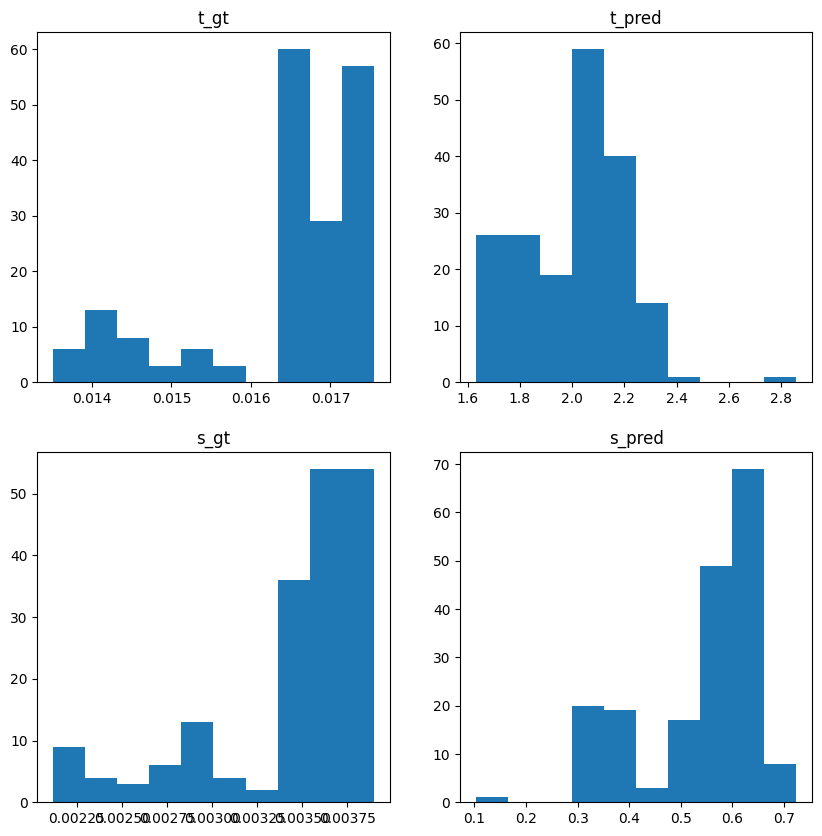

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,2,figsize = (10,10))
ax[0,0].set_title('t_gt')
ax[0,1].set_title('t_pred')
ax[0,0].hist(t_gt)
ax[0,1].hist(t_pred)

ax[1,0].set_title('s_gt')
ax[1,1].set_title('s_pred')
ax[1,0].hist(s_gt)
ax[1,1].hist(s_pred)

In [ ]:
from models.SurgeDepth.dpt import SurgeDepth
import torch

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}
model = SurgeDepth(**model_configs['vitb']).cuda()
# torch.no_grad()
state_dict = torch.load('models/SurgeDepth/checkpoint_5_epochs.pth',weights_only=False)
model_state_dict = state_dict['model']
model.load_state_dict(model_state_dict)
torch.save(model.state_dict(),'models/SurgeDepth/SurgeDepthStudent_V6.pth')

In [15]:
import numpy as np
EndoDAC                  =      np.array([0.144, 2.213, 12.413, 0.177, 0.804, 0.990, 1.000, 30.392, 0.618])
DepthAnythingv2        =        np.array([0.147, 2.359, 12.773, 0.185, 0.805, 0.974, 0.999, 30.337, 0.619])
DepthAnything           =       np.array([0.102, 1.260, 9.434 ,0.131 ,0.894 ,0.997 ,1.000 ,32.118 ,0.625])
DinoV2DPT               =       np.array([0.162, 2.752, 13.751, 0.194, 0.740, 0.979, 0.999, 29.848, 0.600])
SurgeDepthours        =         np.array([0.211, 4.638, 18.381, 0.264, 0.596, 0.891, 0.997, 28.462, 0.604])
EndoDaccut                  =   np.array([0.136, 1.653, 10.672, 0.175, 0.814, 0.983, 0.995, 29.453, 0.675])
DepthAnythingv2cut        =     np.array([0.191, 3.231, 14.239, 0.240, 0.643, 0.947, 0.995, 28.261, 0.669])
DepthAnythingcut           =    np.array([0.221, 3.696, 15.144, 0.251, 0.514, 0.975, 0.996, 27.244, 0.661])
DinoV2DPTcut              =     np.array([0.178, 2.449, 12.264, 0.214, 0.671, 0.980, 0.995, 28.970, 0.655])
SurgeDepthourscut        =      np.array([0.139, 1.845, 11.020, 0.189, 0.802, 0.987, 0.994, 29.145, 0.677])


ED = (EndoDAC*63+EndoDaccut*151)/(151+63)
DA2 = (DepthAnythingv2*63+DepthAnythingv2cut*151)/(151+63)
DA = (DepthAnythingv2*63+DepthAnythingcut*151)/(151+63)
DI = (DinoV2DPT*63+DinoV2DPTcut*151)/(151+63)
SD = (SurgeDepthours*63+SurgeDepthourscut*151)/(151+63)

print("{:.03f}&{:.03f}&{:.03f}&{:.03f}&{:.03f}&{:.03f}&{:.03f}&{:.03f}&{:.03f}".format(*ED))
print("{:.03f}&{:.03f}&{:.03f}&{:.03f}&{:.03f}&{:.03f}&{:.03f}&{:.03f}&{:.03f}".format(*DA2))
print("{:.03f}&{:.03f}&{:.03f}&{:.03f}&{:.03f}&{:.03f}&{:.03f}&{:.03f}&{:.03f}".format(*DA))
print("{:.03f}&{:.03f}&{:.03f}&{:.03f}&{:.03f}&{:.03f}&{:.03f}&{:.03f}&{:.03f}".format(*DI))
print("{:.03f}&{:.03f}&{:.03f}&{:.03f}&{:.03f}&{:.03f}&{:.03f}&{:.03f}&{:.03f}".format(*SD))

0.138&1.818&11.185&0.176&0.811&0.985&0.996&29.729&0.658
0.178&2.974&13.807&0.224&0.691&0.955&0.996&28.872&0.654
0.199&3.302&14.446&0.232&0.600&0.975&0.997&28.155&0.649
0.173&2.538&12.702&0.208&0.691&0.980&0.996&29.228&0.639
0.160&2.667&13.187&0.211&0.741&0.959&0.995&28.944&0.656


In [13]:
print("{:.03f}&{:.03f}&{:.03f}&{:.03f}&{:.03f}&{:.03f}&{:.03f}&{:.03f}&{:.03f}".format(*ED))

0.140&1.835&11.290&0.177&0.819&0.994&1.006&30.010&0.664
